In [1]:
!pip install --upgrade xgboost scikit-learn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
df = pd.read_csv('https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv')
df

<ipython-input-3-bbdfef5df3d9>:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://rakamin-lms.s3.ap-southeast-1.amazonaws.com/vix-assets/idx-partners/loan_data_2007_2014.csv')


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,...,NaN,NaN,NaN,NaN,NaN,NaN,29900.0,NaN,NaN,NaN
466281,466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,...,NaN,NaN,NaN,NaN,NaN,NaN,39400.0,NaN,NaN,NaN
466282,466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,...,NaN,NaN,NaN,NaN,NaN,NaN,13100.0,NaN,NaN,NaN
466283,466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,...,NaN,NaN,NaN,NaN,NaN,NaN,53100.0,NaN,NaN,NaN


# Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

Terdapat 75 kolom dengan 466285 baris data bertipe int, float, dan object.

Penjelasan tiap kolom tabel adalah sebagai berikut.

1. Unnamed: 0                     = indeks

2. id                             = ID unik

3. member_id                      = ID unik peminjam

4. loan_amnt                      = pembayaran bulan lalu yang telah diterima

5. funded_amnt                    = jumlah total yang berkomitmen untuk pinjaman saat itu

6. funded_amnt_inv                = jumlah total pinjaman dari investor

7. term                           = Jumlah pembayaran pinjaman. Nilai dalam bulan dan dapat berupa 36 atau 60.

8. int_rate                       = Menunjukkan apakah pendapatan telah diverifikasi oleh LC, tidak diverifikasi, atau jika sumber pendapatan telah diverifikasi

9.   installment                  = Pembayaran bulanan yang harus dibayar oleh peminjam.

10.  grade                        = Tingkat pinjaman yang ditetapkan

11.  sub_grade                    = Subtingkat pinjaman yang ditetapkan

12.  emp_title                    = Jabatan peminjam

13.  emp_length                   = Lamanya masa kerja dalam tahun. Nilai yang mungkin adalah antara 0 dan 10 dimana 0 berarti kurang dari satu tahun dan 10 berarti sepuluh tahun atau lebih.

14.  home_ownership               = Status kepemilikan rumah yang diberikan oleh peminjam pada saat pendaftaran. Nilai-nilai kami adalah: RENT, OWN, MORTGAGE, OTHER.

15.  annual_inc                   = Pendapatan tahunan peminjam

16.  verification_status          = Status verifikasi

17.  issue_d                      = Bulan saat peminjaman didanai

18.  loan_status                  = Status pinjaman saat ini

19.  pymnt_plan                   = Rencana pembayaran

20.  url                          = URL halaman LC

21.  desc                         = Deskripsi pinjaman

22.  purpose                      = Kategori yang disediakan oleh peminjam untuk permintaan pinjaman.

23.  title                        = Judul pinjaman

24.  zip_code                     = 3 angka pertama kode pos yang diberikan peminjam dalam permohonan pinjaman.

25.  addr_state                   = Negara yang disediakan oleh peminjam dalam permohonan pinjaman

26.  dti                          = Rasio yang dihitung menggunakan total pembayaran utang bulanan peminjam terhadap total kewajiban utang, tidak termasuk hipotek dan pinjaman LC yang diminta, dibagi dengan pendapatan bulanan peminjam yang dilaporkan sendiri.

27.  delinq_2yrs                  = Jumlah tunggakan tunggakan lebih dari 30 hari dalam arsip kredit peminjam selama 2 tahun terakhir

28.  earliest_cr_line             = Tanggal pembukaan batas kredit paling awal yang dilaporkan peminjam

29.  inq_last_6mths               = Jumlah pertanyaan kredit dalam 12 bulan terakhir

30.  mths_since_last_delinq       = Jumlah bulan sejak tunggakan terakhir peminjam.

31.  mths_since_last_record       = Jumlah bulan sejak pencatatan publik terakhir.

32.  open_acc                     = Jumlah jalur kredit terbuka dalam file kredit peminjam.

33.  pub_rec                      = Jumlah catatan publik yang bersifat merugikan

34.  revol_bal                    = Total saldo kredit bergulir

35.  revol_util                   = Tingkat pemanfaatan jalur bergulir, atau jumlah kredit yang digunakan peminjam relatif terhadap seluruh kredit bergulir yang tersedia.        

36.  total_acc                    = Jumlah total batas kredit yang saat ini ada dalam arsip kredit peminjam

37.  initial_list_status          = Status pencatatan awal pinjaman. Nilai yang mungkin adalah – Utuh, Pecahan

38.  out_prncp                    = Sisa pokok terutang untuk jumlah total yang didanai

39.  out_prncp_inv                = Sisa pokok terutang untuk sebagian dari jumlah total yang didanai oleh investor

40.  total_pymnt                  = Pembayaran diterima sampai saat ini untuk jumlah total yang didanai

41.  total_pymnt_inv              = Pembayaran yang diterima sampai saat ini untuk sebagian dari jumlah total yang didanai oleh investor

42.  total_rec_prncp              = Pokoknya diterima sampai saat ini

43.  total_rec_int                = Bunga yang diterima sampai saat ini

44.  total_rec_late_fee           = Biaya keterlambatan diterima sampai saat ini

45.  recoveries                   = Menunjukkan apakah rencana pembayaran telah diterapkan untuk pinjaman

46.  collection_recovery_fee      = biaya pos dari biaya pengumpulan

47.  last_pymnt_d                 = Pembayaran bulan lalu telah diterima

48.  last_pymnt_amnt              = Jumlah pembayaran bulan lalu telah diterima

49.  next_pymnt_d                 = Tanggal pembayaran terjadwal berikutnya

50.  last_credit_pull_d           = Bulan kredit terakhir ditarik

51.  collections_12_mths_ex_med   = Jumlah koleksi dalam 12 bulan tidak termasuk koleksi medis

52.  mths_since_last_major_derog  = Bulan sejak rating 90 hari terakhir atau lebih buruk

53.  policy_code                  = "policy_code=1 yang tersedia untuk umum
produk baru tidak tersedia untuk umum policy_code=2"

54.  application_type             = Menunjukkan apakah pinjaman tersebut merupakan permohonan perorangan atau permohonan bersama dengan dua peminjam bersama

55.  annual_inc_joint             = Gabungan pendapatan tahunan yang dilaporkan sendiri yang diberikan oleh peminjam bersama pada saat pendaftaran

56.  dti_joint                    = Rasio yang dihitung menggunakan total pembayaran bulanan peminjam bersama atas total kewajiban utang, tidak termasuk hipotek dan pinjaman LC yang diminta, dibagi dengan gabungan pendapatan bulanan yang dilaporkan sendiri oleh peminjam bersama

57.  verification_status_joint    = Menunjukkan apakah pendapatan bersama peminjam bersama telah diverifikasi oleh LC, tidak diverifikasi, atau jika sumber pendapatan telah diverifikasi

58.  acc_now_delinq               = Jumlah rekening dimana peminjam sekarang menunggak.

59.  tot_coll_amt                 = Total jumlah penagihan yang terutang

60.  tot_cur_bal                  = Total saldo saat ini dari semua akun

61.  open_acc_6m                  = Jumlah perdagangan terbuka dalam 6 bulan terakhir

62.  open_il_6m                   = Jumlah perdagangan bergulir yang dibuka dalam 6 bulan terakhir

63.  open_il_12m                  = Jumlah perdagangan bergulir yang dibuka dalam 12 bulan terakhir

64.  open_il_24m                  = Jumlah perdagangan bergulir yang dibuka dalam 24 bulan terakhir

65.  mths_since_rcnt_il           = Bulan sejak rekening cicilan terakhir dibuka

66.  total_bal_il                 = Total saldo saat ini dari semua rekening angsuran

67.  il_util                      = Rasio total saldo saat ini terhadap kredit/batas kredit yang tinggi pada semua akun pemasangan

68.  open_rv_12m                  = Jumlah perdagangan bergulir yang dibuka dalam 12 bulan terakhir

69.  open_rv_24m                  = Jumlah perdagangan bergulir yang dibuka dalam 24 bulan terakhir

70.  max_bal_bc                   = Saldo terhutang maksimum saat ini pada semua akun bergulir

71.  all_util                     = Saldo hingga batas kredit pada semua perdagangan

72.  total_rev_hi_lim             = Total batas kredit/kredit tinggi yang bergulir

73.  inq_fi                       = Jumlah pertanyaan keuangan pribadi

74.  total_cu_tl                  = Jumlah perdagangan keuangan

75.  inq_last_12m                = Jumlah pertanyaan kredit dalam 12 bulan terakhir

## Hapus kolom

Hapus kolom yang memiliki >70% null-data.

In [5]:
df.drop(df.isna().sum()[lambda x : x> 0.7*len(df)].index, axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  466285 non-null  int64  
 1   id                          466285 non-null  int64  
 2   member_id                   466285 non-null  int64  
 3   loan_amnt                   466285 non-null  int64  
 4   funded_amnt                 466285 non-null  int64  
 5   funded_amnt_inv             466285 non-null  float64
 6   term                        466285 non-null  object 
 7   int_rate                    466285 non-null  float64
 8   installment                 466285 non-null  float64
 9   grade                       466285 non-null  object 
 10  sub_grade                   466285 non-null  object 
 11  emp_title                   438697 non-null  object 
 12  emp_length                  445277 non-null  object 
 13  home_ownership

In [7]:
col = []
val = []
for key, value in df.items():
  col.append(key)
  val.append(value.unique())
d = pd.DataFrame({'column':col, 'unique values':val})
d

,column,unique values
0,Unnamed: 0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,id,"[1077501, 1077430, 1077175, 1076863, 1075358, ..."
2,member_id,"[1296599, 1314167, 1313524, 1277178, 1311748, ..."
3,loan_amnt,"[5000, 2500, 2400, 10000, 3000, 7000, 5600, 53..."
4,funded_amnt,"[5000, 2500, 2400, 10000, 3000, 7000, 5600, 53..."
5,funded_amnt_inv,"[4975.0, 2500.0, 2400.0, 10000.0, 3000.0, 5000..."
6,term,"[ 36 months, 60 months]"
7,int_rate,"[10.65, 15.27, 15.96, 13.49, 12.69, 7.9, 18.64..."
8,installment,"[162.87, 59.83, 84.33, 339.31, 67.79, 156.46, ..."
9,grade,"[B, C, A, E, F, D, G]"


Tersisa 54 kolom. Selanjutnya, kita hapus beberapa kolom untuk memudahkan dan memfokuskan analisis.



*   Kolom ***Unnamed: 0, id***, dan ***member_id*** dihapus karena ID tidak memengaruhi analisis
*   Kolom ***url*** dihapus karena tidak diperlukan dalam analisis
*   Kolom ***title*** dan ***emp_title*** tidak diperlukan dalam analisis
*   Alamat peminjam tidak diperlukan sehingga kolom ***zip_code*** dan ***add_state*** dihapus.
*   Kolom ***application type*** dan ***policy_code*** dihapus karena hanya memiliki 1 nilai unik.







In [8]:
df.drop(columns=['Unnamed: 0', 'id', 'member_id','url', 'zip_code', 'title', 'addr_state', 'policy_code', 'application_type', 'title', 'emp_title'], inplace=True)

In [9]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,...,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,466140.000000,466256.000000,3.960090e+05,3.960090e+05,3.960090e+05
mean,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,...,2588.677225,0.650129,85.344211,8.961534,3123.913796,0.009085,0.004002,1.919135e+02,1.388017e+05,3.037909e+04
std,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,...,2483.809661,5.265730,552.216084,85.491437,5554.737393,0.108648,0.068637,1.463021e+04,1.521147e+05,3.724713e+04
min,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,...,957.280000,0.000000,0.000000,0.000000,312.620000,0.000000,0.000000,0.000000e+00,2.861800e+04,1.350000e+04
50%,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,...,1818.880000,0.000000,0.000000,0.000000,545.960000,0.000000,0.000000,0.000000e+00,8.153900e+04,2.280000e+04
75%,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,...,3304.530000,0.000000,0.000000,0.000000,3187.510000,0.000000,0.000000,0.000000e+00,2.089530e+05,3.790000e+04
max,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,33.000000,188.000000,...,24205.620000,358.680000,33520.270000,7002.190000,36234.440000,20.000000,5.000000,9.152545e+06,8.000078e+06,9.999999e+06


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 45 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   funded_amnt                 466285 non-null  int64  
 2   funded_amnt_inv             466285 non-null  float64
 3   term                        466285 non-null  object 
 4   int_rate                    466285 non-null  float64
 5   installment                 466285 non-null  float64
 6   grade                       466285 non-null  object 
 7   sub_grade                   466285 non-null  object 
 8   emp_length                  445277 non-null  object 
 9   home_ownership              466285 non-null  object 
 10  annual_inc                  466281 non-null  float64
 11  verification_status         466285 non-null  object 
 12  issue_d                     466285 non-null  object 
 13  loan_status   

Sekarang tersisa 45 kolom dengan 30 kolom numerik dan sisanya adalah kolom kategori.

## Membuat kolom target

Karena tidak ada kolom target analisis, kita akan buat berdasarkan status pinjaman dari peminjam saat ini.






In [11]:
df['loan_status'].value_counts()

,count
loan_status,
Current,224226
Fully Paid,184739
Charged Off,42475
Late (31-120 days),6900
In Grace Period,3146
Does not meet the credit policy. Status:Fully Paid,1988
Late (16-30 days),1218
Default,832
Does not meet the credit policy. Status:Charged Off,761


Kolom ***risk*** merupakan status risiko peminjam yang terdiri dari 3 nilai unik yang didasarkan pada nilai kolom **loan_status**:

*   **Low** : peminjam berisiko rendah untuk gagal bayar kredit. Terdiri dari nilai "Fully paid", "Current", "In Grace Period", dan "Does not meet the credit policy. Status:Fully Paid" pada kolom **loan_status**
*   **High** : peminjam berisiko tinggi untuk gagal bayar kredit. Terdiri dari nilai "Charged Off", "Does not meet the credit policy. Status:Charged Off", "Default", "Late (16-30 days)", dan "Late (31-120 days) pada kolom **loan_status**

Nilai "Default" dimasukkan ke dalam risiko tinggi karena kita tidak mengetahui apakah peminjam dapat membayar pinjaman tepat waktu atau tidak, jadi kita masukkan ke dalam status risiko tinggi guna menghindari hal-hal yang tidak diinginkan (peminjam gagal bayar kredit).

In [12]:
df['risk'] = np.where((df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid') | (df['loan_status'] == 'Current') | (df['loan_status'] == "In Grace Period"), 'Low',
                               'High')
df['risk'].value_counts()

,count
risk,
Low,414099
High,52186


In [13]:
#hapus kolom loan_status karena tidak akan lagi digunakan
df.drop(columns=['loan_status'], inplace=True)

# Exploratory Data Analysis

## Analisis univariat

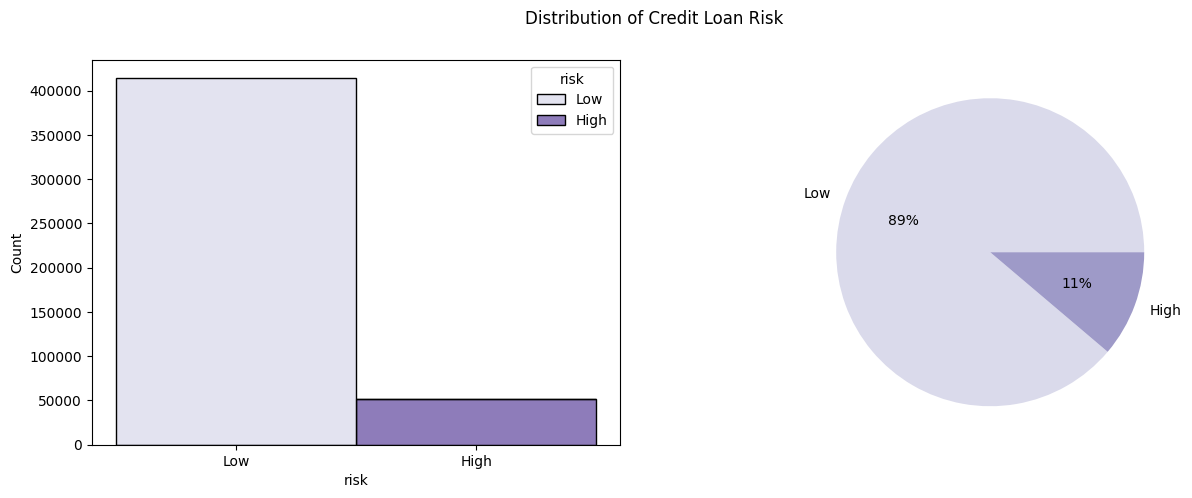

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
palette = sns.color_palette('Purples', n_colors=3)
sns.histplot(ax = axes[0], data=df, x='risk', hue = 'risk', multiple='stack', palette={'Low': palette[0], 'High': palette[2]})
axes[1].pie(df['risk'].value_counts(), labels= ['Low', 'High'], colors=palette[0:2], autopct='%.0f%%')
fig.suptitle('Distribution of Credit Loan Risk')
fig.show()

Hasil:

Mayoritas (>80%) pinjaman berisiko rendah.



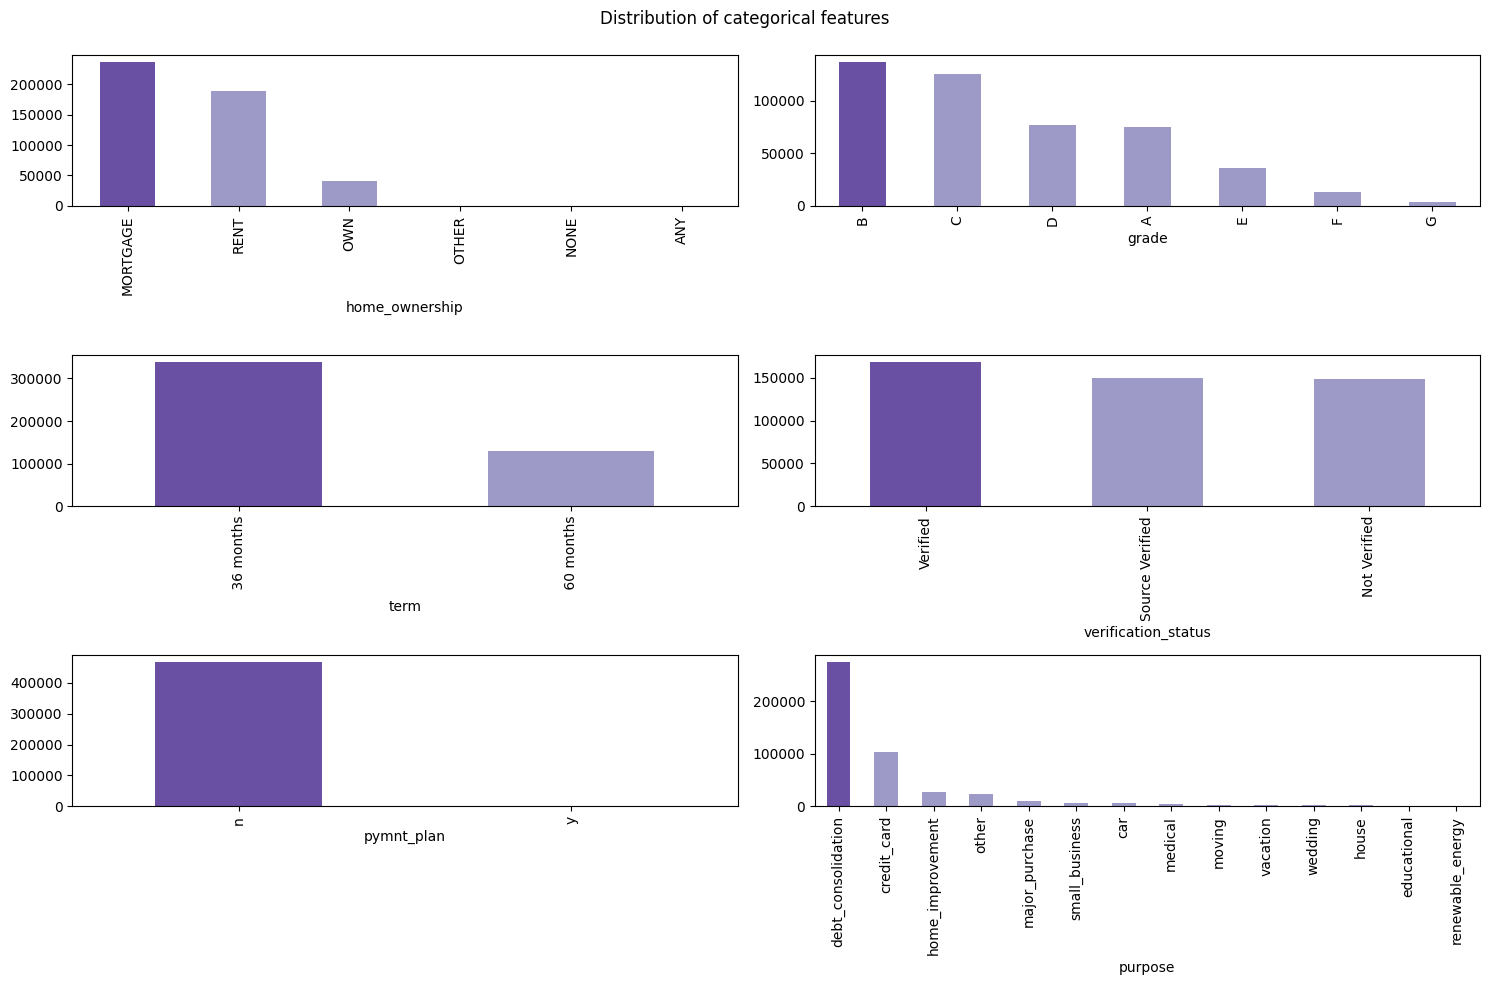

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
colors = [palette[2] if category == df['home_ownership'].value_counts().idxmax() else palette[1] for category in df['home_ownership'].value_counts().index]
df['home_ownership'].value_counts().plot(ax=axes[0,0], kind='bar',color=colors)

colors = [palette[2] if category == df['grade'].value_counts().idxmax() else palette[1] for category in df['grade'].value_counts().index]
df['grade'].value_counts().plot(ax=axes[0,1], kind='bar',color=colors)

colors = [palette[2] if category == df['term'].value_counts().idxmax() else palette[1] for category in df['term'].value_counts().index]
df['term'].value_counts().plot(ax=axes[1,0], kind='bar',color=colors)

colors = [palette[2] if category == df['verification_status'].value_counts().idxmax() else palette[1] for category in df['verification_status'].value_counts().index]
df['verification_status'].value_counts().plot(ax=axes[1,1], kind='bar',color=colors)

colors = [palette[2] if category == df['pymnt_plan'].value_counts().idxmax() else palette[1] for category in df['pymnt_plan'].value_counts().index]
df['pymnt_plan'].value_counts().plot(ax=axes[2,0], kind='bar',color=colors)

colors = [palette[2] if category == df['purpose'].value_counts().idxmax() else palette[1] for category in df['purpose'].value_counts().index]
df['purpose'].value_counts().plot(ax=axes[2,1], kind='bar',color=colors)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Distribution of categorical features')
fig.show()

Hasil:
- Rumah peminjam kebanyakan adalah KPR (MORTRAGE).
- Kelas paling banyak adalah B.
- Termin paling banyak adalah 36 bulan.
- Peminjam kebanyakan sudah memiliki rencana pembayaran dan status peminjam telah diverifikasi.
- Kebanyakan tujuan peminjam adalah membayar utang.

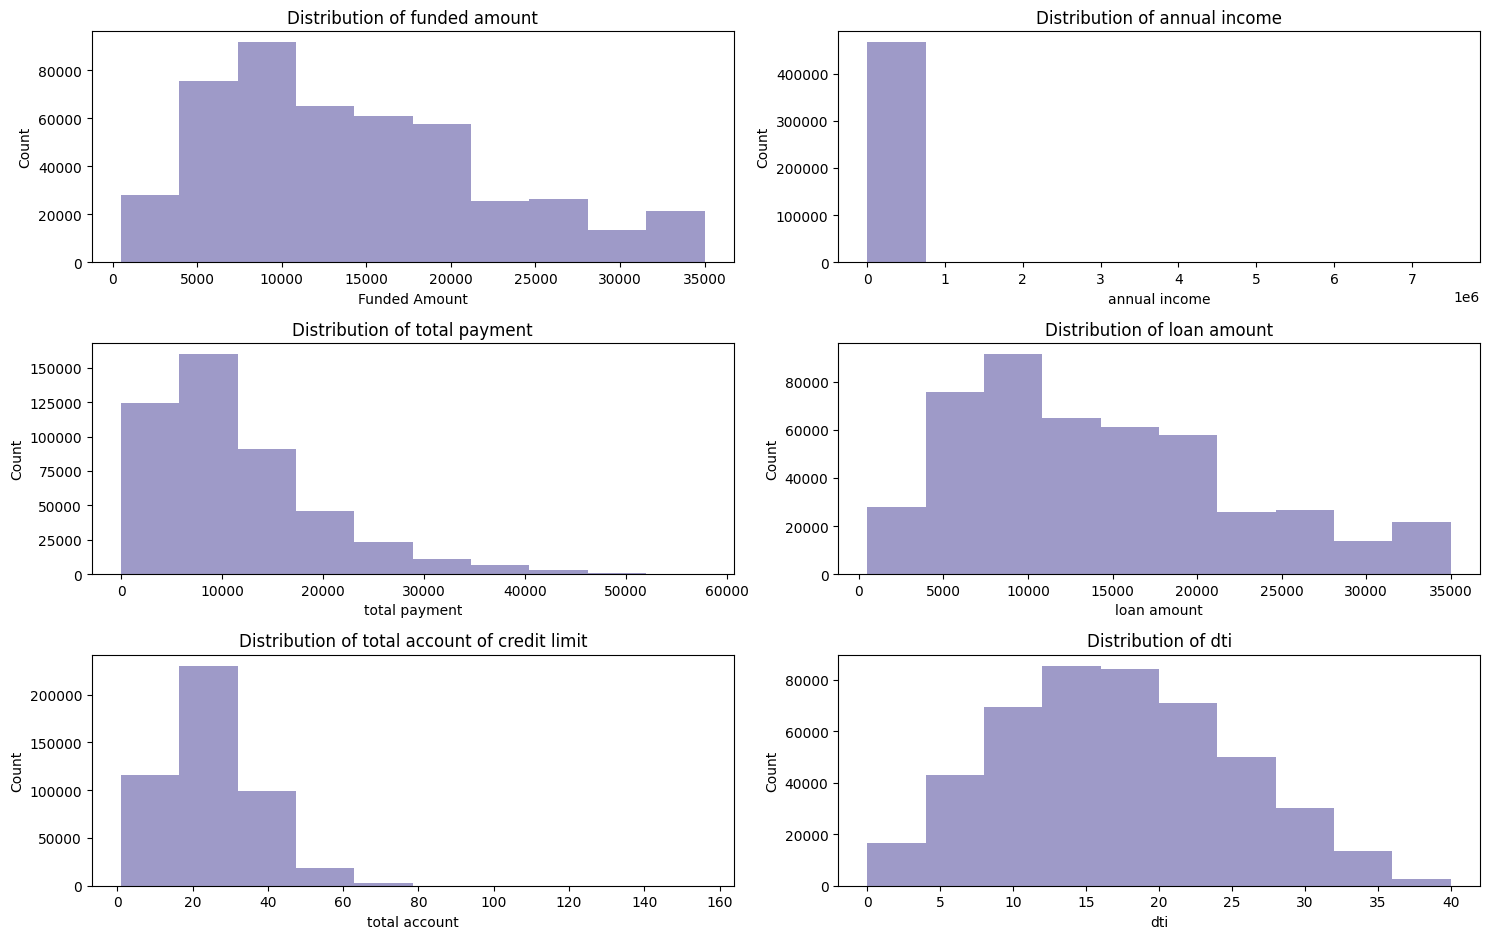

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes[0,0].hist(df['funded_amnt'], color=palette[1])
axes[0,0].set_title('Distribution of funded amount')
axes[0,0].set_xlabel('Funded Amount')
axes[0,0].set_ylabel('Count')

axes[0,1].hist(df['annual_inc'], color=palette[1])
axes[0,1].set_title('Distribution of annual income')
axes[0,1].set_xlabel('annual income')
axes[0,1].set_ylabel('Count')

axes[1,0].hist(df['total_pymnt'], color=palette[1])
axes[1,0].set_title('Distribution of total payment')
axes[1,0].set_xlabel('total payment')
axes[1,0].set_ylabel('Count')

axes[1,1].hist(df['loan_amnt'], color=palette[1])
axes[1,1].set_title('Distribution of loan amount')
axes[1,1].set_xlabel('loan amount')
axes[1,1].set_ylabel('Count')

axes[2,1].hist(df['dti'], color=palette[1])
axes[2,1].set_title('Distribution of dti')
axes[2,1].set_xlabel('dti')
axes[2,1].set_ylabel('Count')

axes[2,0].hist(df['total_acc'], color=palette[1])
axes[2,0].set_title('Distribution of total account of credit limit')
axes[2,0].set_xlabel('total account')
axes[2,0].set_ylabel('Count')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Hasil:

*   Kolom **funded_amnt**, **total_pymnt**, **loan_amnt**, **total_acc**, dan **dti** lebih condong ke kanan.
*   **Pendapatan** peminjam (berdasarkan kolom **annual_inc**) mayoritas berada **di bawah 1.000.000**



## Analisis bivariat

In [17]:
#buat fungsi berisi data yang telah dinormalisasi berdasarkan proporsi risiko
def norm(df,col1,col2):
  counts = df.groupby([col1, col2]).size().reset_index(name='count')
  total_counts = counts.groupby(col1)['count'].transform('sum')
  counts['proportion'] = counts['count'] / total_counts
  return counts

home_risk = norm(df, 'home_ownership', 'risk') #kepemilikan rumah
grade_risk = norm(df, 'grade', 'risk') #tingkat pinjaman
term_risk = norm(df, 'term', 'risk') #jangka waktu pinjaman
verif_risk = norm(df, 'verification_status', 'risk') #status verifikasi
purpose_risk = norm(df, 'purpose', 'risk') #tujuan pinjaman
payplan_risk = norm(df, 'pymnt_plan', 'risk') #apakah rencana pembayaran telah diterapkan

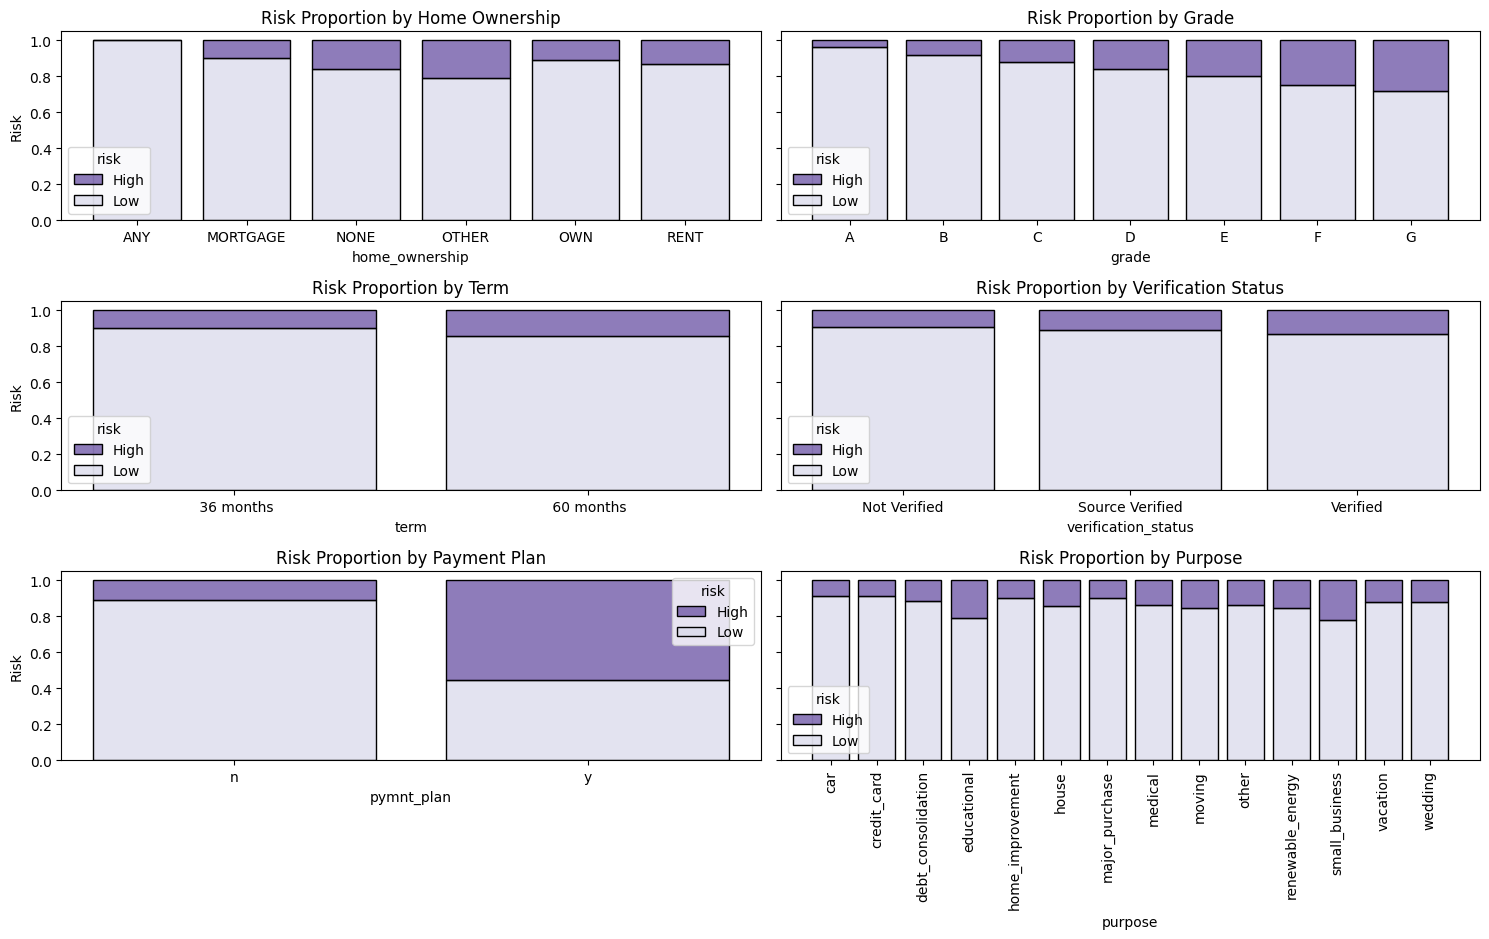

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=True)
palette = sns.color_palette('Purples', n_colors=3)
sns.histplot(ax = axes[0,0], data=home_risk, x='home_ownership',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
axes[0,0].set_title('Risk Proportion by Home Ownership')
axes[0,0].set_ylabel('Risk')

sns.histplot(ax = axes[0,1], data=grade_risk, x='grade',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
axes[0,1].set_title('Risk Proportion by Grade')
axes[0,1].set_ylabel('Risk')

sns.histplot(ax = axes[1,0], data=term_risk, x='term',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
axes[1,0].set_title('Risk Proportion by Term')
axes[1,0].set_ylabel('Risk')

sns.histplot(ax = axes[1,1], data=verif_risk, x='verification_status',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
axes[1,1].set_title('Risk Proportion by Verification Status')
axes[1,1].set_ylabel('Risk')

sns.histplot(ax = axes[2,1], data=purpose_risk, x='purpose',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
plt.xticks(rotation=90)
axes[2,1].set_title('Risk Proportion by Purpose')
axes[2,1].set_ylabel('Risk')

sns.histplot(ax = axes[2,0], data=payplan_risk, x='pymnt_plan',
             hue = 'risk', hue_order= ['High', 'Low'],
             weights='proportion', multiple='stack',
             palette={'Low': palette[0], 'High': palette[2]},
             shrink=.8)
axes[2,0].set_title('Risk Proportion by Payment Plan')
axes[2,0].set_ylabel('Risk')

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Hasil:


*   Peminjam yang **tidak memiliki status kepemilikan rumah (OTHER atau NONE)** memiliki **risiko lebih tinggi** jika kredit pinjaman disetujui
*   Semakin **tinggi kelas**, tingkat **risiko pinjaman meningkat**. Kelas G lebih tinggi tingkatnya dari A.

*   Pinjaman berjangka **60 bulan berisiko lebih tinggi**.
*   **Status verifikasi** pada risiko pinjaman/kredit tinggi dan rendah **hampir sama**.
*   **Rencana peminjaman** yang telah **dilaksanakan (y)** ternyata lebih banyak **berisiko tinggi**.
*   Tujuan dari **peminjaman yang berisiko tinggi** kebanyakan adalah untuk **pendidikan dan bisnis kecil (UMKM)**







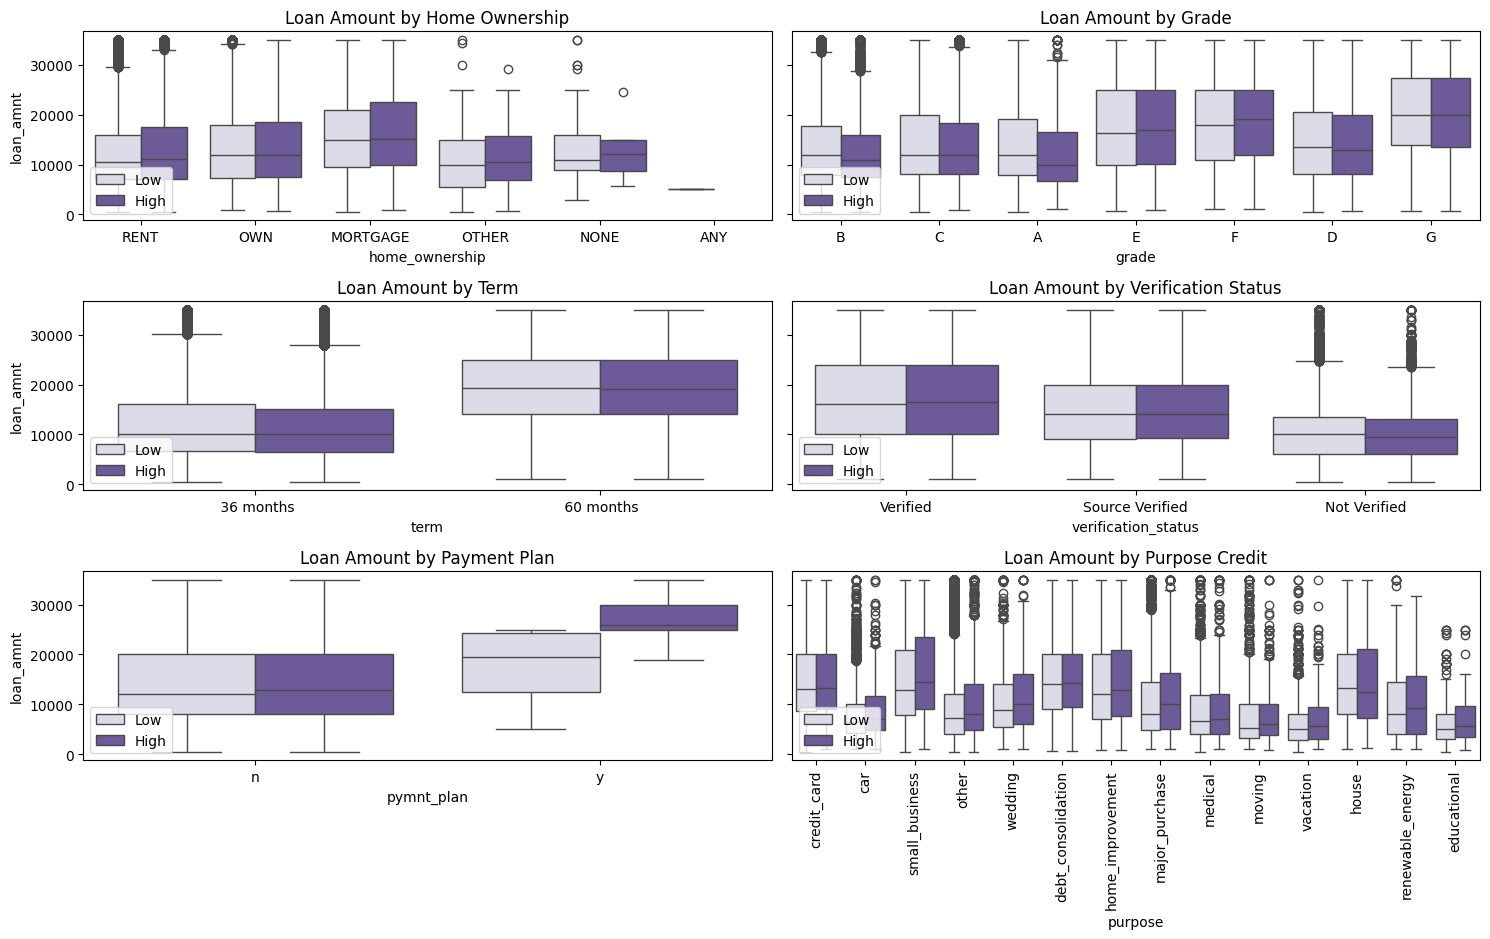

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharey=True)
sns.boxplot(ax= axes[0,0], data=df, x='home_ownership', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[0,0].set_title('Loan Amount by Home Ownership')
axes[0,0].legend(loc='lower left')

sns.boxplot(ax= axes[0,1], data=df, x='grade', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[0,1].set_title('Loan Amount by Grade')
axes[0,1].legend(loc='lower left')

sns.boxplot(ax= axes[1,0], data=df, x='term', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[1,0].set_title('Loan Amount by Term')
axes[1,0].legend(loc='lower left')

sns.boxplot(ax= axes[1,1], data=df, x='verification_status', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[1,1].set_title('Loan Amount by Verification Status')
axes[1,1].legend(loc='lower left')

sns.boxplot(ax= axes[2,1], data=df, x='purpose', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[2,1].set_title('Loan Amount by Purpose Credit')
plt.xticks(rotation=90)
axes[2,1].legend(loc='lower left')

sns.boxplot(ax= axes[2,0], data=df, x='pymnt_plan', y='loan_amnt',
            hue='risk', palette={'Low': palette[0], 'High': palette[2]})
axes[2,0].set_title('Loan Amount by Payment Plan')

fig.tight_layout(rect=[0, 0, 1, 0.95])
axes[2,0].legend(loc='lower left')
plt.show()

Hasil:

*   Pembayaran kredit yang diterima bulan lalu paling banyak berasal dari peminjam dengan kepemilikan rumah **MORTGAGE**.
*   Kelas **G** menyumbang pembayaran kredit yang diterima bulan lalu **paling banyak** dan kelas **B** menyumbang **paling sedikit**.
*   Kredit berjangka waktu **60 bulan** **paling banyak menyumbang** pembayaran kredit yang diterima bulan lalu.
*   Pembayaran kredit yang diterima bulan lalu kebanyakan **telah diverifikasi**.
*   Pembayaran kredit yang diterima bulan lalu kebanyakan**telah memiliki rencana pembayaran**.
*   Kredit yang diterima bulan lalu kebanyakan berasal dari pinjaman untuk **bisnis kecil**.







# Data Preparation

## Handling missing value

In [20]:
df.isnull().sum() #periksa kolom yang nilainya kosong

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,21008
home_ownership,0


Untuk mengisi nilai kosong pada data, akan dilakukan imputasi dengan nilai **median** untuk **kolom numerik** (float dan int) serta nilai **modus** untuk kolom **kategori** (object). Selain itu, kolom yang memiliki nilai kosong lebih dari 10% akan dihapus.

In [21]:
#hapus kolom yang memiliki >10% data null
missing_percentage = df.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 10].index
df = df.drop(columns=columns_to_drop)

In [22]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq,risk
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,0.0,Low
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,0.0,High
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,0.0,Low
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,0.0,Low
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,1009.07,0.00,0.00,0.00,Jan-16,67.79,Jan-16,0.0,0.0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,18400,18400,18400.0,60 months,14.47,432.64,C,C2,4 years,MORTGAGE,...,4557.36,0.00,0.00,0.00,Jan-16,432.64,Jan-16,0.0,0.0,Low
466281,22000,22000,22000.0,60 months,19.97,582.50,D,D5,10+ years,MORTGAGE,...,2840.88,0.00,0.00,0.00,Dec-14,17.50,Jan-16,0.0,0.0,High
466282,20700,20700,20700.0,60 months,16.99,514.34,D,D1,7 years,MORTGAGE,...,6072.29,0.00,0.00,0.00,Jan-16,514.34,Dec-15,0.0,0.0,Low
466283,2000,2000,2000.0,36 months,7.90,62.59,A,A4,3 years,OWN,...,126.58,0.00,0.00,0.00,Dec-14,1500.68,Apr-15,0.0,0.0,Low


In [23]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    df[column] = df[column].fillna(df[column].median())

In [24]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for column in categorical_columns:
    df[column] = df[column].fillna(df[column].mode()[0])

In [25]:
#periksa kembali nilai kosong pada data
df.isnull().sum()

,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_length,0
home_ownership,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   funded_amnt                 466285 non-null  int64  
 2   funded_amnt_inv             466285 non-null  float64
 3   term                        466285 non-null  object 
 4   int_rate                    466285 non-null  float64
 5   installment                 466285 non-null  float64
 6   grade                       466285 non-null  object 
 7   sub_grade                   466285 non-null  object 
 8   emp_length                  466285 non-null  object 
 9   home_ownership              466285 non-null  object 
 10  annual_inc                  466285 non-null  float64
 11  verification_status         466285 non-null  object 
 12  issue_d                     466285 non-null  object 
 13  pymnt_plan    

In [27]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [28]:
df['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [29]:
df['sub_grade'].unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

## Duplicated data

In [30]:
df['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [31]:
df.duplicated().sum()

0

Tidak terdapat duplikasi data.

## Feature engineering

Untuk melihat bagaimana histori dari tiap peminjam, akan dibuat kolom baru:


*   **loan_leng** : durasi utang sejak bulan didanainya pinjaman sampai bulan peminjam membayar utang.
*   **loan_age**: umur pinjaman terakhir untuk melihat durasi peminjam berutang sejak bulan saat pinjaman didanai sampai terakhir kredit ditarik.
*   **credit_duration**: durasi kredit disetujui sejak tanggal pembukaan batas kredit paling awal sampai bulan saat pinjaman didanai.








In [32]:
#ubah kolom issue_d, earliest_d, last_pymnt_d, dan last_credit_pull_d
#menjadi bertipe datetime
df['issue'] = pd.to_datetime(df['issue_d'], format="%b-%y", errors='coerce')
df['earliest'] = pd.to_datetime(df['earliest_cr_line'], format="%b-%y", errors='coerce')
df['last_pymnt'] = pd.to_datetime(df['last_pymnt_d'], format="%b-%y", errors='coerce')
df['last_credit'] = pd.to_datetime(df['last_credit_pull_d'], format="%b-%y", errors='coerce')

#buat kolom loan_leng
df['loan_leng'] = (df['last_pymnt'] - df['issue']).dt.days

#buat kolom loan_age
df['loan_age'] = (df['last_credit'] - df['issue']).dt.days

#buat kolom credit_duration
df['credit_duration'] = (df['issue'] - df['earliest']).dt.days

#hapus kolom yang tidak digunakan lagi
df.drop(columns=['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], inplace=True)

## Outlier

Untuk memilih metode yang digunakan dalam deteksi outlier, kita akan lihat *skewness* dari data numerik.

In [33]:
num_col = df.select_dtypes(include=['float64', 'int64'])
skewed_features = num_col.skew().sort_values(ascending=False)
print(skewed_features)

collections_12_mths_ex_med    31.225134
annual_inc                    29.569024
collection_recovery_fee       22.236096
acc_now_delinq                20.798942
revol_bal                     19.476291
pub_rec                       14.941738
total_rec_late_fee            13.843497
recoveries                    13.149942
delinq_2yrs                    5.345914
last_pymnt_amnt                2.560644
total_rec_int                  2.268276
inq_last_6mths                 2.142214
out_prncp_inv                  1.590503
out_prncp                      1.590189
loan_age                       1.551020
total_rec_prncp                1.445591
total_pymnt                    1.406403
total_pymnt_inv                1.404658
open_acc                       1.165772
installment                    0.949293
total_acc                      0.813117
funded_amnt                    0.734845
loan_amnt                      0.730980
funded_amnt_inv                0.730250
loan_leng                      0.613642


Ternyata, sebagian besar data sangat condong ke kanan (**skewness >1**). Kita akan gunakan metode Isolation Forest untuk mendeteksi anomali/outlier. Keunggulan dari metode ini adalah cocok untuk data multi dimensional dan data yang tidak berdistribusi normal.

In [34]:
iso_forest = IsolationForest(
    n_estimators=100,  # Number of trees (100 is a good balance)
    max_samples=5000,  # Subsampling (use a smaller number for faster computation)
    contamination='auto',  # Automatically detect contamination level
    random_state=42,  # Ensures reproducibility
    n_jobs=-1  # Use all available CPU cores
)
df["outlier_score"] = iso_forest.fit_predict(num_col)

# Identikasi outlier (-1 adalah outlier)
outliers = df[df["outlier_score"] == -1]
print(f"Total outliers detected: {len(outliers)}")


Total outliers detected: 6013


Kita akan hapus outlier karena jumlahnya relatif sangat sedikit dari total.

In [35]:
df = df[df['outlier_score'] != -1]
df.shape

(460272, 44)

## Feature Selection

### Encoding categorical feature

Kita ubah data kategori menjadi numerik dengan melakukan feature encoding.

In [36]:
df2 = df.copy()
df2['grade'] = LabelEncoder().fit_transform(df2['grade'])
df2['sub_grade'] = LabelEncoder().fit_transform(df2['sub_grade'])
df2['emp_length'] = LabelEncoder().fit_transform(df2['emp_length'])
df2['pymnt_plan'] = LabelEncoder().fit_transform(df2['pymnt_plan'])
df2['initial_list_status'] = LabelEncoder().fit_transform(df2['initial_list_status'])
df2['risk'] = df2['risk'].map({'Low':0, 'High': 1})

Dilakukan juga one-hot encoding pada kolom **term, home_ownership, verification_status**, dan **purpose**

In [37]:
df1 = df2.copy()  # Create a copy outside the loop

for col in ['term', 'home_ownership', 'verification_status', 'purpose']:
    one_hot_encoded = pd.get_dummies(df2[[col]], prefix=col, drop_first=False)

    # Convert boolean columns in one_hot_encoded to int64
    for column in one_hot_encoded.select_dtypes(include=['bool']).columns:
        one_hot_encoded[column] = one_hot_encoded[column].astype(np.int64)

    df1 = pd.merge(df1, one_hot_encoded, left_index=True, right_index=True, how='left')
    df1 = df1.drop(columns=[col])

In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460272 entries, 0 to 466284
Data columns (total 65 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   loan_amnt                            460272 non-null  int64         
 1   funded_amnt                          460272 non-null  int64         
 2   funded_amnt_inv                      460272 non-null  float64       
 3   int_rate                             460272 non-null  float64       
 4   installment                          460272 non-null  float64       
 5   grade                                460272 non-null  int64         
 6   sub_grade                            460272 non-null  int64         
 7   emp_length                           460272 non-null  int64         
 8   annual_inc                           460272 non-null  float64       
 9   pymnt_plan                           460272 non-null  int64         
 10  d

### Korelasi

Dilakukan seleksi fitur berdasarkan korelasi Pearson terhadap kolom target (**risk**) 20 fitur teratas.

In [39]:
corr_matrix = df1.corr(numeric_only=True) #korelasi
# 20 fitur dengan korelasi tertinggi terhadap kolom risk
top_features = corr_matrix['risk'].abs().sort_values(ascending=False)[:20]
#data 20 fitur top korelasi
data_top = df1[top_features.index.to_list()]
#data korelasi untuk ditampilkan dalam heatmap
corr_top_20 = corr_matrix.loc[top_features.index, top_features.index]

In [40]:
top_features

,risk
risk,1.000000
recoveries,0.475029
collection_recovery_fee,0.334142
total_rec_prncp,0.255754
total_pymnt_inv,0.204304
total_pymnt,0.204071
loan_leng,0.188416
int_rate,0.170082
last_pymnt_amnt,0.169691
sub_grade,0.166382


5 fitur teratas yang berkorelasi tinggi terhadap **risk** adalah fitur **recoveries, collection_recovery_fee, total_rec_prncp, total_pymnt_inv**, dan **total_pymnt**

Untuk melihat korelasi antar fitur, kita lakukan visualisasi heatmap.

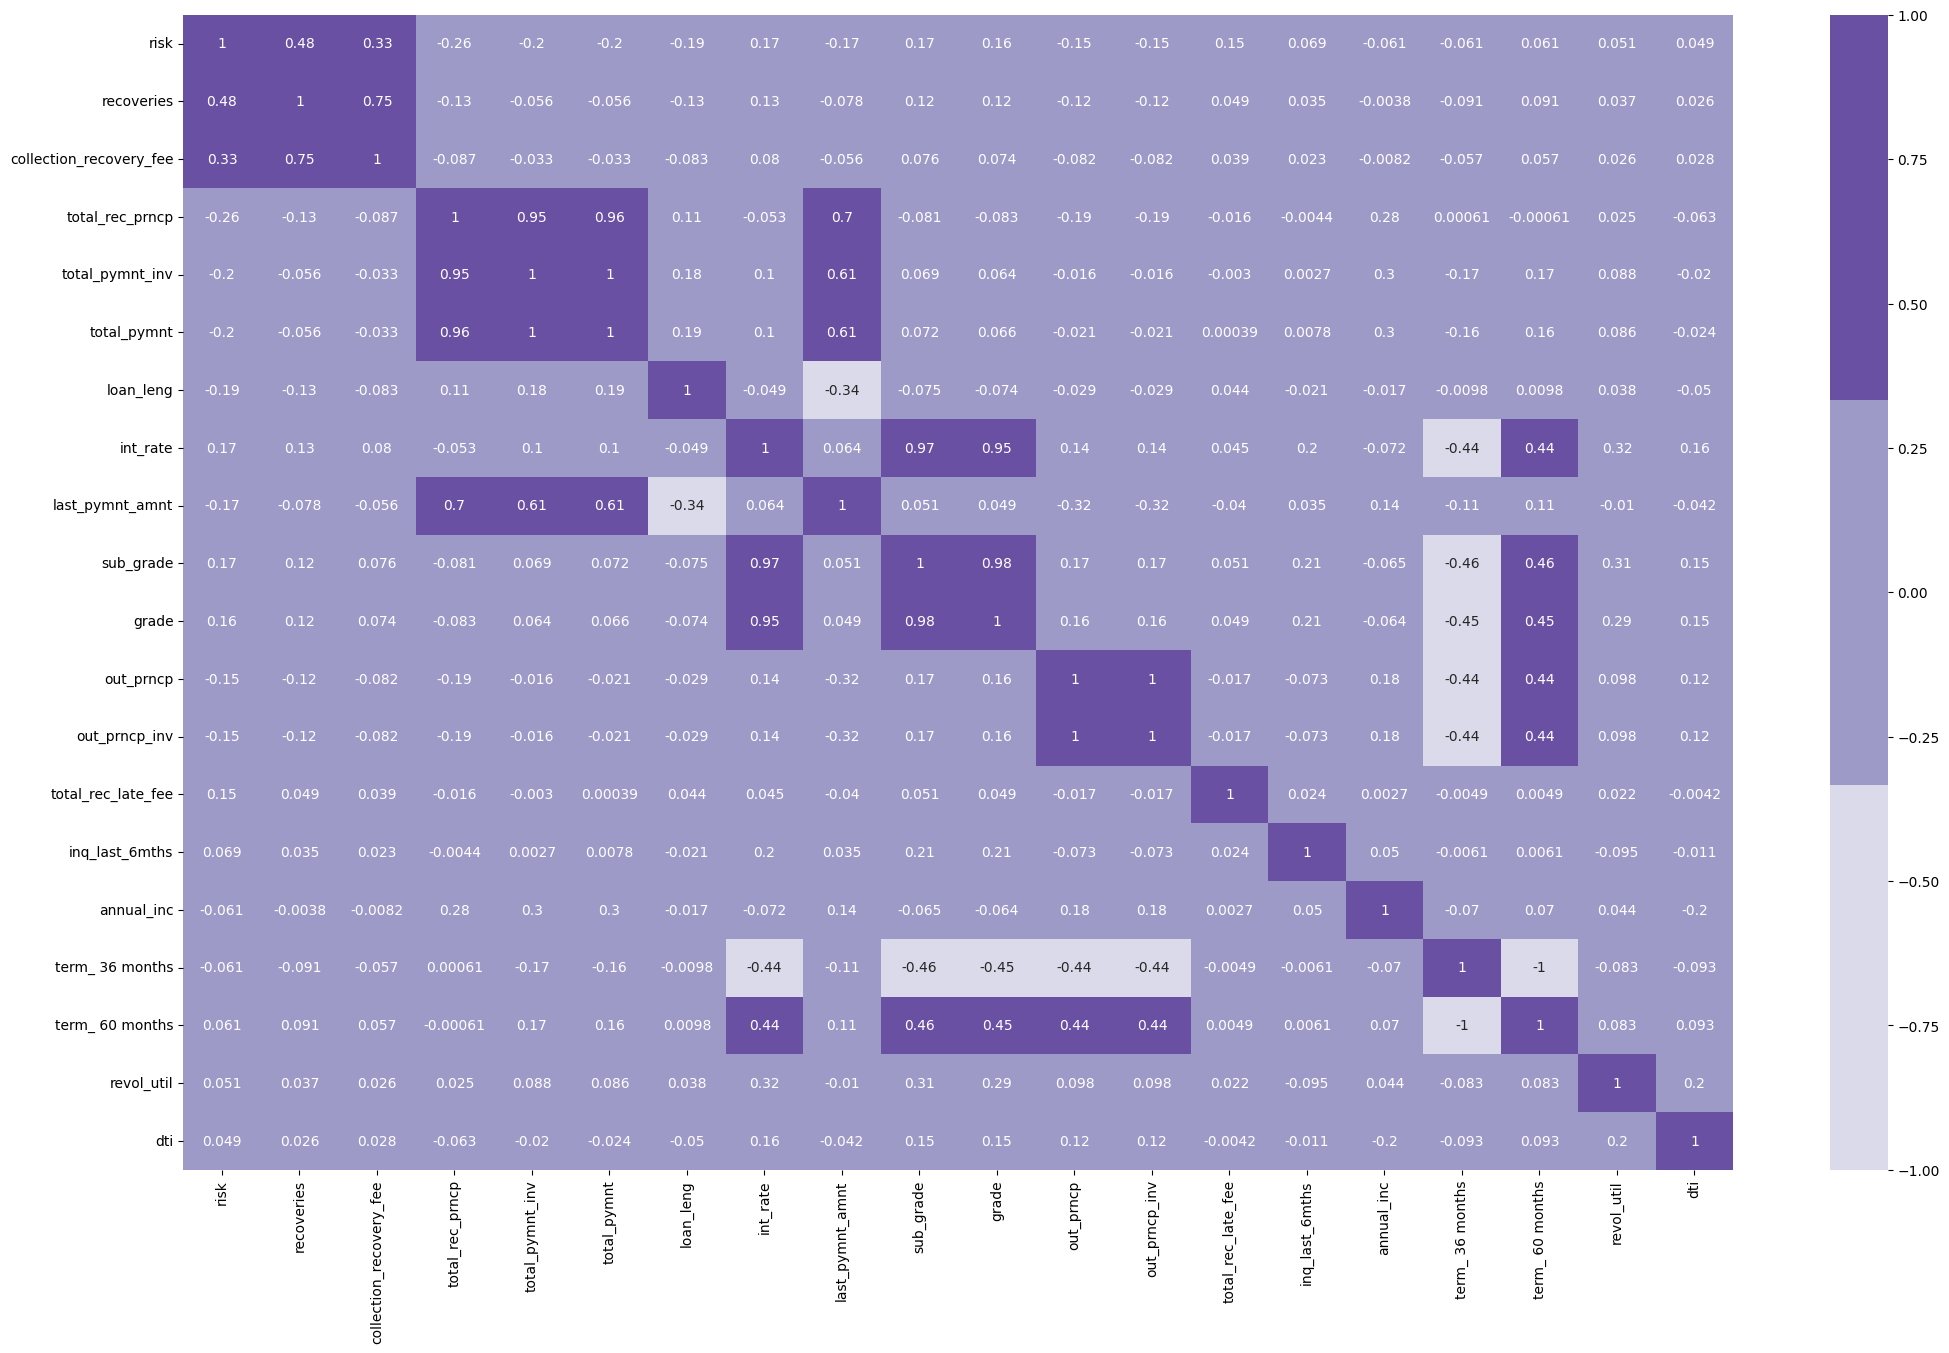

In [41]:
plt.figure(figsize=(25,15))
sns.heatmap(corr_top_20, cmap=palette, annot=True)
plt.show()

Hasil:

Beberapa kolom numerik memiliki korelasi sangat tinggi (>0.7), yakni:

*   **total_pymnt_inv** dengan **total_pymnt** berkorelasi 1
*   **out_prncp_inv** dengan **out_prncp** berkorelasi 1
*   **total_pymnt_inv** dengan **total_rec_prncp** berkorelasi 0.95
*   **total_pymnt** dengan **total_rec_prncp** berkorelasi 0.96
*   **sub_grade** dengan **int_rate** berkorelasi 0.97
*   **grade** dengan **int_rate** berkorelasi 0.95
*   **grade** dengan **sub_grade** berkorelasi 0.98
*   **recoveries** dengan **collection_recovery_fee** berkorelasi 0.75

Diantara kolom **total_pymnt_inv, total_pymnt**, dan **total_rec_prncp**, kita akan gunakan kolom **total_pymnt** karena menunjukkan jumlah dana pinjaman yang diterima dari peminjam.

Kemudian, diantara kolom **grade, sub_grade**, dan **int_rate** kita pertahankan kolom **grade** karena menunjukkan kelas/tingkat pinjaman.

Lalu, diantara kolom **out_prncp** dan **out_prncp_inv**, kita pilih kolom **out_prncp** yang menunjukkan sisa pokok terutang dari jumlah pokok yang didanai.

Terakhir, diantara kolom **recoveries** dan **collection_recovery_fee**, kita pilih kolom **recoveries** yang menunjukkan apakah peminjam telah memiliki rencana pembayaran.









In [42]:
final = data_top.drop(columns=['total_pymnt_inv', 'total_rec_prncp', 'sub_grade', 'int_rate', 'collection_recovery_fee', 'out_prncp_inv'])

In [43]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460272 entries, 0 to 466284
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   risk                460272 non-null  int64  
 1   recoveries          460272 non-null  float64
 2   total_pymnt         460272 non-null  float64
 3   loan_leng           460272 non-null  int64  
 4   last_pymnt_amnt     460272 non-null  float64
 5   grade               460272 non-null  int64  
 6   out_prncp           460272 non-null  float64
 7   total_rec_late_fee  460272 non-null  float64
 8   inq_last_6mths      460272 non-null  float64
 9   annual_inc          460272 non-null  float64
 10  term_ 36 months     460272 non-null  int64  
 11  term_ 60 months     460272 non-null  int64  
 12  revol_util          460272 non-null  float64
 13  dti                 460272 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 52.7 MB


Terdapat 14 kolom yang digunakan dalam analisis dan model *machine learning*

## Data split

Kita gunakan train-test set dengan proposi 80:20. *Train set* digunakan untuk melatih data pada algoritma *machine learning*.  Sementara itu, *test set* digunakan dalam evaluasi model *machine learning*.

In [44]:
X = final.drop(columns=['risk'])
y = final['risk']

# Pisah 80% untuk training dan 20% untuk testing
X_train, X_test, y_train, y_tst = train_test_split(X,y, test_size=0.2, random_state=42)


In [45]:
len(X_train)

368217

## Standarisasi

In [46]:
X_train.describe()

,recoveries,total_pymnt,loan_leng,last_pymnt_amnt,grade,out_prncp,total_rec_late_fee,inq_last_6mths,annual_inc,term_ 36 months,term_ 60 months,revol_util,dti
count,368217.000000,368217.000000,368217.000000,368217.000000,368217.000000,368217.000000,368217.000000,368217.000000,3.682170e+05,368217.000000,368217.000000,368217.000000,368217.000000
mean,68.774701,11315.343632,607.738594,3047.437405,1.797532,4386.037979,0.555556,0.795968,7.206548e+04,0.728500,0.271500,56.155929,17.224942
std,412.461448,7935.213411,289.264068,5382.417450,1.305793,6292.841864,4.458872,1.076832,4.767360e+04,0.444734,0.444734,23.667444,7.840768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.300000e+03,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5511.900000,426.000000,311.050000,1.000000,0.000000,0.000000,0.000000,4.500000e+04,0.000000,0.000000,39.300000,11.370000
50%,0.000000,9313.380000,549.000000,538.590000,2.000000,514.210000,0.000000,0.000000,6.200000e+04,1.000000,0.000000,57.500000,16.870000
75%,0.000000,15056.788110,791.000000,3132.940000,3.000000,7331.950000,0.000000,1.000000,8.700000e+04,1.000000,1.000000,74.600000,22.780000
max,17579.140000,49229.359980,2405.000000,36170.140000,6.000000,31681.540000,294.680000,32.000000,7.446395e+06,1.000000,1.000000,892.300000,39.990000


Karena tiap kolom memiliki persebaran yang jauh berbeda, kita lakukan standarisasi.

In [47]:
scale = StandardScaler()
col_to_scale = ['recoveries', 'total_pymnt', 'loan_leng', 'last_pymnt_amnt',
                'grade', 'out_prncp', 'total_rec_late_fee', 'inq_last_6mths',
                'annual_inc', 'revol_util', 'dti']
X_train[col_to_scale] = scale.fit_transform(X_train[col_to_scale])
X_test[col_to_scale] = scale.fit_transform(X_test[col_to_scale])

# Data Modeling

## Logistic regression

In [48]:
lr_start_time = time.time()
lr = LogisticRegression(solver= 'liblinear', penalty= 'l2',tol=1e-8, C=40, max_iter=1000, dual=True,
                        random_state=42)
lr.fit(X_train, y_train)
lr_end_time = time.time()
lr_execution_time = lr_end_time - lr_start_time
print('Logistic regression has trained')
print(f"Execution time: {lr_execution_time} seconds")

Logistic regression has trained
Execution time: 251.11981439590454 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Random Forest

In [49]:
rf_start_time = time.time()
rf = RandomForestClassifier(random_state=42, n_estimators=300)
rf.fit(X_train, y_train)
rf_end_time = time.time()
rf_execution_time = rf_end_time - rf_start_time
print('Random Forest has trained')
print(f"Execution time: {rf_execution_time} seconds")

Random Forest has trained
Execution time: 385.565575838089 seconds


## XGBoost

In [50]:
xgb_start_time = time.time()
xgb = XGBClassifier(random_state=42, max_depth=10, learning_rate=0.01)
xgb.fit(X_train, y_train)
xgb_end_time = time.time()
xgb_execution_time = xgb_end_time - xgb_start_time
print('XGBoost has trained')
print(f"Execution time: {xgb_execution_time} seconds")

XGBoost has trained
Execution time: 5.026196718215942 seconds


In [51]:
y_val_pred_rf = rf.predict(X_test)

# Evaluation

## Training set score

In [52]:
#Logistic regression
y_pred_lr_train = lr.predict(X_train)
acc_lr_train = round(accuracy_score(y_train, y_pred_lr_train), 4)
pre_lr_train = round(precision_score(y_train, y_pred_lr_train),4)
rec_lr_train = round(recall_score(y_train, y_pred_lr_train),4)
f1_lr_train = round(f1_score(y_train, y_pred_lr_train),4)

#Random Forest
y_pred_rf_train = rf.predict(X_train)
acc_rf_train = round(accuracy_score(y_train, y_pred_rf_train),4)
pre_rf_train = round(precision_score(y_train, y_pred_rf_train),4)
rec_rf_train = round(recall_score(y_train, y_pred_rf_train),4)
f1_rf_train = round(f1_score(y_train, y_pred_rf_train),4)

#XGBoost
y_pred_xgb_train = xgb.predict(X_train)
acc_xgb_train = round(accuracy_score(y_train, y_pred_xgb_train),4)
pre_xgb_train = round(precision_score(y_train, y_pred_xgb_train),4)
rec_xgb_train = round(recall_score(y_train, y_pred_xgb_train),4)
f1_xgb_train = round(f1_score(y_train, y_pred_xgb_train),4)

## Testing set score

In [53]:
#Logistic regression
y_pred_lr_test = lr.predict(X_test)
acc_lr_test = round(accuracy_score(y_tst, y_pred_lr_test),4)
pre_lr_test = round(precision_score(y_tst, y_pred_lr_test),4)
rec_lr_test = round(recall_score(y_tst, y_pred_lr_test),4)
f1_lr_test = round(f1_score(y_tst, y_pred_lr_test),4)

#Random Forest
y_pred_rf_test = rf.predict(X_test)
acc_rf_test = round(accuracy_score(y_tst, y_pred_rf_test),4)
pre_rf_test = round(precision_score(y_tst, y_pred_rf_test),4)
rec_rf_test = round(recall_score(y_tst, y_pred_rf_test),4)
f1_rf_test = round(f1_score(y_tst, y_pred_rf_test),4)

#XGBoost
y_pred_xgb_test = xgb.predict(X_test)
acc_xgb_test = round(accuracy_score(y_tst, y_pred_xgb_test),4)
pre_xgb_test = round(precision_score(y_tst, y_pred_xgb_test),4)
rec_xgb_test = round(recall_score(y_tst, y_pred_xgb_test),4)
f1_xgb_test = round(f1_score(y_tst, y_pred_xgb_test),4)

## Perbandingan tiap algoritma

In [55]:
diff = pd.DataFrame({'Name': ['Logistic regression', 'Random forest', 'XGBoost'],
                     'accuracy (train)': [acc_lr_train, acc_rf_train, acc_xgb_train],
                     'accuracy (test)': [acc_lr_test, acc_rf_test, acc_xgb_test],
                     'precision (train)': [pre_lr_train, pre_rf_train, pre_xgb_train],
                     'precision (test)': [pre_lr_test, pre_rf_test, pre_xgb_test],
                     'recall (train)': [rec_lr_train, rec_rf_train, rec_xgb_train],
                     'recall (test)': [rec_lr_test, rec_rf_test, rec_xgb_test],
                     'f1 (train)': [f1_lr_train, f1_rf_train, f1_xgb_train],
                     'f1 (test)': [f1_lr_test, f1_rf_test, f1_xgb_test],
                    'time (s)': [lr_execution_time, rf_execution_time, xgb_execution_time]})
diff

,Name,accuracy (train),accuracy (test),precision (train),precision (test),recall (train),recall (test),f1 (train),f1 (test),time (s)
0,Logistic regression,0.9523,0.9545,0.9181,0.8939,0.6217,0.6499,0.7414,0.7526,251.119814
1,Random forest,1.0000,0.9735,1.0000,0.8937,1.0000,0.8524,1.0000,0.8726,385.565576
2,XGBoost,0.9759,0.9741,0.9807,0.9453,0.7968,0.8039,0.8792,0.8689,5.026197


## Confusion matrix

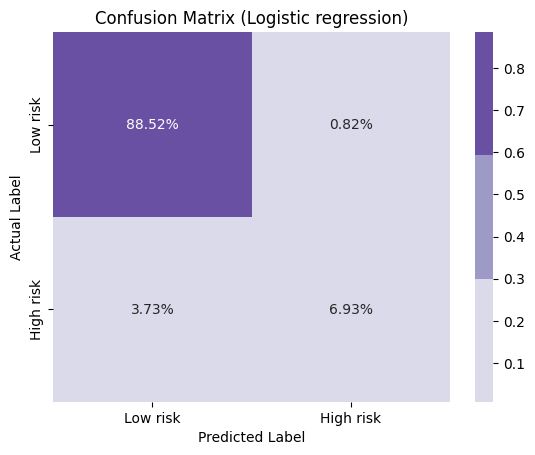

In [56]:
cm = confusion_matrix(y_tst, y_pred_lr_test)
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap=palette, xticklabels=["Low risk", "High risk"],
            yticklabels=["Low risk", "High risk"])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Logistic regression)")
plt.show()

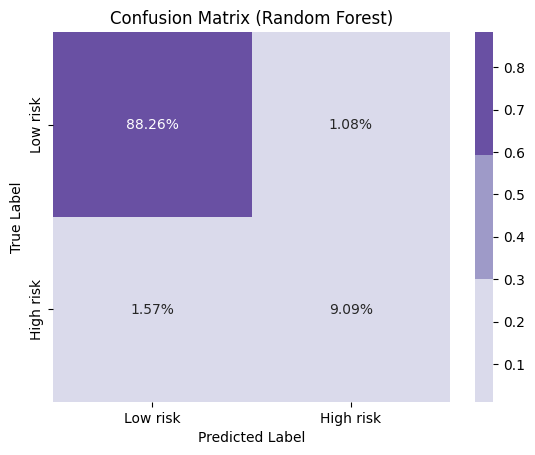

In [57]:
cm = confusion_matrix(y_tst, y_pred_rf_test)
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap=palette, xticklabels=["Low risk", "High risk"],
            yticklabels=["Low risk", "High risk"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

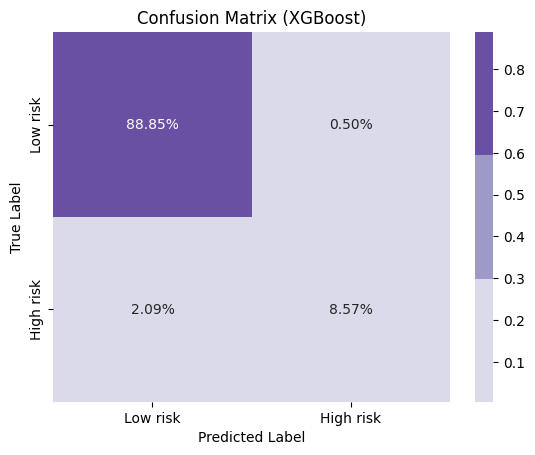

In [58]:
cm = confusion_matrix(y_tst, y_pred_xgb_test)
sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap=palette, xticklabels=["Low risk", "High risk"],
            yticklabels=["Low risk", "High risk"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (XGBoost)")
plt.show()



*   Random Forest memiliki akurasi yang sangat baik, tapi kemungkinan overfit tinggi. Artinya, saat diberi data lain, model ini belum bisa menangkap pola dengan baik. Selain itu, waktu komputasinya sangat lama.
*   Logistic regression memiliki akurasi yang sangat baik dan tidak overfit, hanya saja recall score sangat kecil.  Artinya, banyak kategori high risk yang diprediksi sebagai low risk yang mana sangat membahayakan. Selain itu, waktu komputasinya juga lama.
*   XGBoost memiliki akurasi sangat baik, tidak overfit, tetapi skor recall relatif lebih kecil dari algoritma RF. Meskipun demikian, presisinya sangat baik, artinya dapat menangkap kasus low risk dengan sangat baik. Kelebihan lain dari algoritma ini adalah waktu komputasinya sangat singkat.

Jadi, untuk prediksi risiko kredit, algoritma yang paling baik adalah **XGBoost**.



